## Classification using Word2Vec and Extra Trees Classifiers

This script describes how text data can be embedded using Word2Vec and used to train Extra Tree classiifers for classification into categories. Here, the text data example used are noise complaints.

In [2]:
import os
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import regex as re
import string
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import dill as pickle

GLOVE_6B_50D_PATH = "glove.6B.50d.txt"
encoding="utf-8"

In [3]:
df = pd.read_csv('./LabelledData.csv', encoding='latin1')
df.head(10)

,CONTENT,CONTENT_label
0,10am to 11am - resd f/b that the many prc ever...,Congregation
1,email i would like to share another feedback o...,Congregation
2,every week from monday to friday about 7pm to ...,Congregation
3,children shouting & playing at v/deck blk 127 ...,Congregation
4,blk 703 and 704 - kids still playing at v/deck...,Congregation
5,grp of youth playing basket ball & making alot...,Congregation
6,youth playing skateboard at mph. very noisy._,Congregation
7,group of people playing music very loud at ope...,Congregation
8,kids playing & shouting @ v/deck. very noisy....,Congregation
9,"few people playing scoccer @ v/deck, very nois...",Congregation


In [4]:
df = df[['CONTENT','CONTENT_label']]
df = df[pd.notnull(df['CONTENT'])]
df.head(10)

,CONTENT,CONTENT_label
0,10am to 11am - resd f/b that the many prc ever...,Congregation
1,email i would like to share another feedback o...,Congregation
2,every week from monday to friday about 7pm to ...,Congregation
3,children shouting & playing at v/deck blk 127 ...,Congregation
4,blk 703 and 704 - kids still playing at v/deck...,Congregation
5,grp of youth playing basket ball & making alot...,Congregation
6,youth playing skateboard at mph. very noisy._,Congregation
7,group of people playing music very loud at ope...,Congregation
8,kids playing & shouting @ v/deck. very noisy....,Congregation
9,"few people playing scoccer @ v/deck, very nois...",Congregation


In [5]:
df.index = range(df.shape[0])

In [6]:
df['CONTENT'].apply(lambda x: len(x.split(' '))).sum() # Number of words in all documents

330064

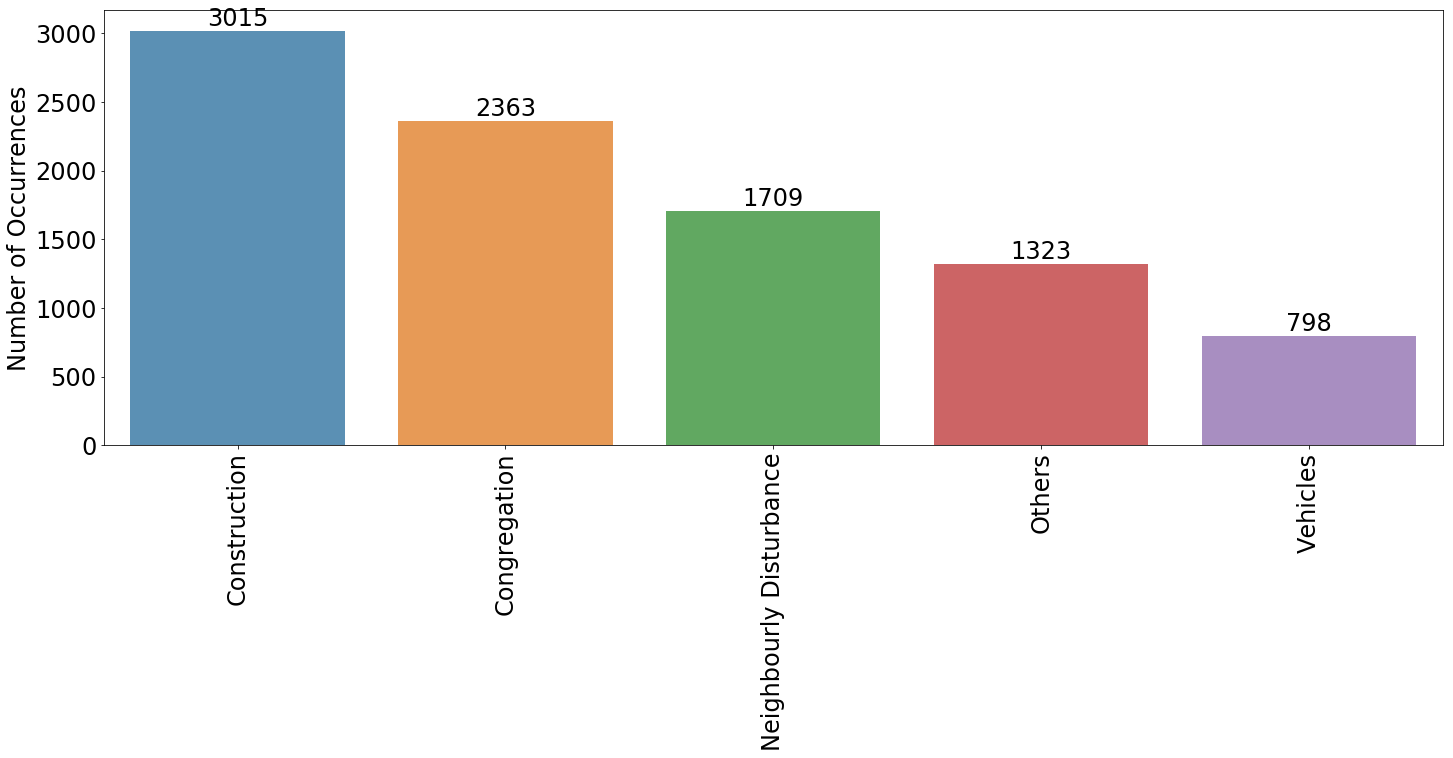

In [7]:
cnt_pro = df['CONTENT_label'].value_counts()

plt.figure(figsize=(24,8))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=24)
# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=24, color='black', ha='center', va='bottom')
plt.xticks(rotation=90, fontsize=24)
plt.yticks(fontsize=24)
plt.show();

In [8]:
def print_complaint(index):
    example = df[df.index == index][['CONTENT', 'CONTENT_label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])

In [9]:
print_complaint(12)

bunch of teenagers playing at badminton court creating noise and littering the place. req to stop them_
Label: Congregation


### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [10]:
def cleanText(text):
    text = re.sub(r'#', r'apartment unit ', text)
    text = re.sub(r'['+string.punctuation+']', r" ", text)
    text = re.sub(r'[0-9]+', r' ', text)
    text = re.sub('\s+', " ", text).strip()
    text = text.lower()
    text = re.sub(r"\bv deck\b", r"voiddeck", text)
    text = re.sub(r"\bvd\b", r"voiddeck", text)
    text = re.sub(r"\bv d\b", r"voiddeck", text)
    text = re.sub(r"\bvdeck\b", r"voiddeck", text)
    text = re.sub(r"\bvoid deck\b", r"voiddeck", text)
    text = re.sub(r"\bfbck\b", r"feedback", text)
    text = re.sub(r"\bfbk\b", r"feedback", text)
    text = re.sub(r"\bf back\b", r"feedback", text)
    text = re.sub(r"\bfback\b", r"feedback", text)
    text = re.sub(r"\bfup\b", r"feedback", text)
    text = re.sub(r"\bfb\b", r"feedback", text)
    text = re.sub(r"\bres\b", r"resident", text)
    text = re.sub(r"\bresd\b", r"resident", text)
    text = re.sub(r"\bresid\b", r"resident", text)
    text = re.sub(r"\breno\b", r"renovation", text)
    text = re.sub(r"\bneighbour\b", r"neighbor", text)
    text = re.sub(r"\bneighbours\b", r"neighbor", text)
    text = re.sub(r"\bneighbors\b", r"neighbor", text)
    text = re.sub(r"\breq\b", r"request", text)
    text = re.sub(r"\brq\b", r"request", text)
    text = re.sub(r"\binfd\b", r"informed", text)
    text = re.sub(r"\badv\b", r"advice", text)
    text = re.sub(r"\badvic\b", r"advice", text)
    text = re.sub(r"\badvis\b", r"advice", text)
    text = re.sub(r"\badvise\b", r"advice", text)
    text = re.sub(r"\badviceeise\b", r"advice", text)
    text = re.sub(r"\bppl\b", r"people", text)
    text = re.sub(r"\bindians\b", r"indian", text)
    text = re.sub(r"\bmalays\b", r"malay", text)
    text = re.sub(r"\bment\b", r"apartment", text)
    text = re.sub(r"\btcil\b", r"towncouncil", text)
    text = re.sub(r"\btown council\b", r"towncouncil", text)
    text = re.sub(r"\bcoffee shop\b", r"coffeeshop", text)
    text = re.sub(r"\breno\b", r"renovation", text)
    text = re.sub(r"\brenov\b", r"renovation", text)
    text = re.sub(r"\bcpark\b", r"carpark", text)
    text = re.sub(r"\bcar park\b", r"carpark", text)
    text = re.sub(r"\bmscp\b", r"multi-storey carpark", text)
    text = re.sub(r"\bmulti storey\b", r"multi-storey", text)
    text = re.sub(r"\bmultistorey\b", r"multi-storey", text)
    text = re.sub(r"\broad work\b", r"roadworks", text)
    text = re.sub(r"\broad works\b", r"roadworks", text)
    text = re.sub(r"\bfrm\b", r"from", text)
    text = re.sub(r"\bgrp\b", r"group", text)
    text = re.sub(r"\bhse\b", r"house", text)
    text = re.sub(r"\bcan t\b", r"cannot", text)
    text = re.sub(r"\bgrp\b", r"group", text)
    text = re.sub(r"\bsaket bord\b", r"skateboard", text)
    text = re.sub(r"\bw out\b", r"without", text)
    text = re.sub(r"\bongg\b", r"ongoing", text)
    text = re.sub(r"\bon gg\b", r"ongoing", text)
    text = re.sub(r"\bfwake\b", r"funeral wake", text)
    text = re.sub(r"\bcorr\b", r"corridor", text)
    text = re.sub(r"\bcorri\b", r"corridor", text)
    text = re.sub(r"\bcorridors\b", r"corridor", text)
    text = re.sub(r"\bpg\b", r"playground", text)
    text = re.sub(r"\bpgd\b", r"playground", text)
    text = re.sub(r"\bpgrd\b", r"playground", text)
    text = re.sub(r"\blway\b", r"linkway", text)
    text = re.sub(r"\bl way\b", r"linkway", text)
    text = re.sub(r"\bcontratcor\b", r"linkway", text)
    text = re.sub(r"\bos\b", r"outside", text) 
    text = re.sub(r"\bo s\b", r"outside", text) 
    text = re.sub(r"\binfd\b", r"informed", text)
    text = re.sub(r"\bfball\b", r"football", text)
    text = re.sub(r"\bfoot ball\b", r"football", text)
    text = re.sub(r"\brtop\b", r"rooftop", text)
    text = re.sub(r"\br top\b", r"rooftop", text)
    text = re.sub(r"\bramping\b", r"revving", text)
    text = re.sub(r"\bramming\b", r"revving", text)
    text = re.sub(r"\bcolln\b", r"collection", text)
    text = re.sub(r"\bcontruction\b", r"construction", text)
    text = re.sub(r"\bconctruction\b", r"construction", text)
    text = re.sub(r"\bpurposed\b", r"purpose", text)
    text = re.sub(r"\bmph\b", r"multi-purpose hall", text)
    text = re.sub(r"\bmphall\b", r"multi-purpose hall", text)
    text = re.sub(r"\bmulti purpose\b", r"multi-purpose", text)
    text = re.sub(r"\bmultipurpose\b", r"multi-purpose", text)
    text = re.sub(r"\bmulti purpos\b", r"multi-purpose", text)
    text = re.sub(r"\bfurnitures\b", r"furniture", text)
    text = re.sub(r"\bchairs\b", r"chair", text)
    text = re.sub(r"\btables\b", r"table", text)
    text = re.sub(r"\bcheers\b", r"cheer", text)
    text = re.sub(r"\bsongs\b", r"song", text)
    text = re.sub(r"\bsepak takraw\b", r"sepaktakraw", text)
    text = re.sub(r"\bbadmointon\b", r"badminton", text)
    text = re.sub(r"\bbadminton court\b", r"badmintoncourt", text)
    text = re.sub(r"\bb minton\b", r"badminton", text)
    text = re.sub(r"\bbasket ball\b", r"basketball", text)
    text = re.sub(r"\bbasketball court\b", r"basketballcourt", text)
    text = re.sub(r"\btakewondo\b", r"taekwondo", text)
    text = re.sub(r"\btaichi\b", r"tai chi", text)
    text = re.sub(r"\bgathing\b", r"gathering", text)
    text = re.sub(r"\bsoccer court\b", r"soccercourt", text)
    text = re.sub(r"\bfootball court\b", r"footballcourt", text)
    return text

In [11]:
df['CONTENT_clean'] = df['CONTENT'].apply(cleanText)
df['CONTENT_clean'].iloc[29]

'group of boys playing soccer basketballcourt making lot of noise again and very dangerous reported nd times'

Define locations of noise and the activities causing it.

In [12]:
# Tag locations and activity to complaints where possible
location = ["void deck",
            "multi-purpose hall",
            "multi-purpose court",
            "multi-purpose plaza",
            "corridor",
            "basketballcourt", 
            "badmintoncourt",
            "soccercourt",
            "footballcourt",
            "playground",
            "carpark",
            "multi-storey carpark",
            "coffeeshop"]

activity = ["mahjong",
            "babies", 
            "crying",
            "dismantling",
            "dismantle",
            "furniture", 
            "drag",
            "hack",
            "push", 
            "drag",
            "kick",            
            "bang",
            "table",
            "chairs", 
            "pull",
            "shout",
            "talk",
            "cheer",
            "play",
            "dance",
            "dancing"
            "music",
            "song",
            "dance",
            "sepaktakraw",
            "skateboard", 
            "wedding", 
            "funeral", 
            "party", 
            "taekwondo",
            "exercise",
            "exercising",
            "wushu",
            "tai chi"]

activity2 = ['basketball',
             'football',
             'soccer',
             'badminton']

In [13]:
df['Location'] = ""

location_lst = "|".join(location)

ind = df.index[df['CONTENT_clean'].str.contains(location_lst)]

for i in ind:
    tmp = []
    for word in location:
        if word in df['CONTENT_clean'].loc[i]:
            tmp.append(word)
    if tmp:
        df['Location'].loc[i] = ','.join(tmp)

df['Location'].head(30)

0                       
1         badmintoncourt
2                       
3                       
4             playground
5        basketballcourt
6     multi-purpose hall
7                       
8                       
9                       
10            playground
11                      
12        badmintoncourt
13    multi-purpose hall
14       basketballcourt
15                      
16                      
17                      
18                      
19                      
20                      
21                      
22                      
23                      
24                      
25                      
26    multi-purpose hall
27                      
28                      
29       basketballcourt
Name: Location, dtype: object

In [14]:
df['Activity'] = ""

activity_lst = "|".join(activity)

ind = df.index[df['CONTENT_clean'].str.contains(activity_lst)]

for i in ind:
    tmp = []
    for word in activity:
        if word in df['CONTENT_clean'].loc[i]:
            tmp.append(word)
    for word in activity2:
        if re.search(r'\b' + word + r'\b', df['CONTENT_clean'].loc[i]):
            tmp.append(word)
    if tmp:
        df['Activity'].loc[i] = ','.join(tmp)

df['Activity'].head(30)

0                          
1            play,badminton
2                      talk
3                shout,play
4                      play
5           play,basketball
6           play,skateboard
7                      play
8                shout,play
9                      play
10                     play
11                     play
12                     play
13              play,soccer
14          play,basketball
15                  funeral
16                         
17                         
18                     talk
19                         
20               shout,play
21                         
22                     play
23                     play
24    shout,play,basketball
25            play,football
26                     play
27              play,soccer
28            play,football
29              play,soccer
Name: Activity, dtype: object

Train/test split of 80/20.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['CONTENT_clean'],df['CONTENT_label'], test_size=0.2, random_state=42)

In [16]:
X_train.iloc[0]

'group of boys playing soccer at voiddeck very noisy and kicking balls at the wall and dirty the place very dangerous for resident'

The function below tokenizes the text data in each row (document) into individual words. Sentences smaller than 3 words and words that correspond to stopwords are discarded.

In [17]:
import nltk
from nltk.corpus import stopwords

def tokenize_text(text, stop_words):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3 or word in stop_words:
                continue
            tokens.append(word.lower())
    return tokens

stop_words = stopwords.words('english')

Tokenize the training and test data.

In [18]:
for i in range(X_train.shape[0]):
    X_train.iloc[i] = tokenize_text(X_train.iloc[i], stop_words)

for i in range(X_test.shape[0]):
    X_test.iloc[i] = tokenize_text(X_test.iloc[i], stop_words)

This is what a training entry looks like.

In [19]:
X_train.iloc[0]

['group',
 'boys',
 'playing',
 'soccer',
 'voiddeck',
 'noisy',
 'kicking',
 'balls',
 'wall',
 'dirty',
 'place',
 'dangerous',
 'resident']

In [20]:
X_train.iloc[30], y_train.iloc[30]

(['elderly',
  'man',
  'playing',
  'radio',
  'loudly',
  'function',
  'hall',
  'refer',
  'lim',
  'tanglin',
  'police',
  'station'],
 'Neighbourly Disturbance')

## Training the model

We'll instantiate a Word2Vec model using Distributed Bag of Words (DBOW). Another approach possible is Skip-gram method. However, for short text data, DBOW performs better.

Prepare word embeddings and train a new one from scratch

In [21]:
import multiprocessing

cores = multiprocessing.cpu_count()

# train word2vec on all the training text
# we're not using test labels, just texts so this is fine
model = Word2Vec(X_train, size=25, window=3, min_count=10, workers=cores)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.vectors)}

In [22]:
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

import struct 

glove_small = {}
all_words = set(w for words in X_train for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

Model definitions

Classifiers using vector embeddings. We will implement an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [23]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Here, we initialize the Extra Tree Classifiers using the Word2Vec model and train them using 2 different vector embeddings defined above. Extra Tree Classifiers are an extension and generalization of Random Forest classifier. Unlike Random Forest, Extra Tree Classifiers do not use bootstrap copies of the training data and selects a cut-point at random. This provides 2 benefits - 1) increased accuracy and 2) reduces computational burden which leads to faster training and classification.

In [24]:
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=250))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=250))])

Run 10-fold cross validation on all the models on the training set to find the model with the best accuracy.

In [26]:
all_models = [
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]


unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=10).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model        score
---------  -------
w2v         0.7951
w2v_tfidf   0.7909


Train the classifer with the best cross validation score.

In [27]:
etree_w2v.fit(X_train,y_train)

# save the model to disk
pickle.dump(etree_w2v, open('noise_categories_model_etree_w2v.pkl', 'wb'))

In [28]:
# load the model from disk
etree_w2v = pickle.load(open('noise_categories_model_etree_w2v.pkl', 'rb'))

y_pred = etree_w2v.predict(X_train)

print(classification_report(y_train, y_pred))

                         precision    recall  f1-score   support

           Congregation       0.99      1.00      1.00      1880
           Construction       1.00      1.00      1.00      2434
Neighbourly Disturbance       1.00      0.99      1.00      1362
                 Others       1.00      0.99      1.00      1047
               Vehicles       1.00      1.00      1.00       643

              micro avg       1.00      1.00      1.00      7366
              macro avg       1.00      1.00      1.00      7366
           weighted avg       1.00      1.00      1.00      7366



So, in general, when trained on the whole data, the accuracy is almost 100% for all categories. This clearly highlights that the model is __overfiiting__ the data as when cross-validated, the accuracy is almost 20% less. This is a known problem with tree-based classifiers. One way to mitigate this is to reduce the number of trees (at the moment, it has been set to 250).

## Running classifer on test set

In [29]:
# load the model from disk
etree_w2v = pickle.load(open('noise_categories_model_etree_w2v.pkl', 'rb'))

In [30]:
y_score = etree_w2v.predict_proba(X_test)
y_pred = etree_w2v.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

           Congregation       0.78      0.84      0.81       483
           Construction       0.88      0.96      0.92       581
Neighbourly Disturbance       0.81      0.82      0.82       347
                 Others       0.56      0.37      0.45       276
               Vehicles       0.66      0.66      0.66       155

              micro avg       0.79      0.79      0.79      1842
              macro avg       0.74      0.73      0.73      1842
           weighted avg       0.78      0.79      0.78      1842

